In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kunjadiyarohit
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


100%|██████████| 612M/612M [00:34<00:00, 18.4MB/s]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
import imghdr
import random

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential

In [5]:
# load csv file

df = pd.read_csv('/content/signnames.csv')
df.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [6]:
training_file = '/content/gtsrb-german-traffic-sign/Train'
testing_file = '/content/gtsrb-german-traffic-sign/Test'

# Use this to store the images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training data
for folder in os.listdir(training_file):
    label = int(folder) # Get the label from the folder name
    folder_path = os.path.join(training_file, folder) # Path to the folder
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file) # Path to the image
        if imghdr.what(file_path) != None: # Check if it's an image
            img = cv2.imread(file_path)
            if img is not None: # Check if the image was loaded correctly
                img = cv2.resize(img, (32, 32)) # Resize image to ensure consistent dimensions
                train_images.append(img)
                train_labels.append(label)

# Load testing data (similar to training data)
for file in os.listdir(testing_file):
    file_path = os.path.join(testing_file, file)
    if imghdr.what(file_path) != None:
        img = cv2.imread(file_path)
        if img is not None: # Check if the image was loaded correctly
            img = cv2.resize(img, (32, 32)) # Resize image to ensure consistent dimensions
            test_images.append(img)
            test_labels.append(int(file.split('.')[0]))

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
print(train_images.shape, train_labels.shape, len(np.unique(train_labels)))
print(test_images.shape, test_labels.shape)

(39209, 32, 32, 3) (39209,) 43
(12630, 32, 32, 3) (12630,)


# Setting up Directory to save model data

In [9]:
project_name = 'Traffic_Sign_Recognition'

model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Data_Augmentation',
    'VGG16_Transfer_Learning'
]

# Base directory
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/Traffic_Sign_Recognition


# Data Analysis

In [10]:
def count_files_in_subdirs(directory, set_name):
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))

    df = pd.DataFrame(counts, index=[set_name])
    return df

train_dir = '/content/gtsrb-german-traffic-sign/Train'

train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

         38     1    13    11   29    18   31   32   30   28  ...     3     7  \
train  2070  2220  2160  1320  270  1200  780  240  450  540  ...  1410  1440   

         17   26   41    10     9     2   33     8  
train  1110  600  240  2010  1470  2250  689  1410  

[1 rows x 43 columns]


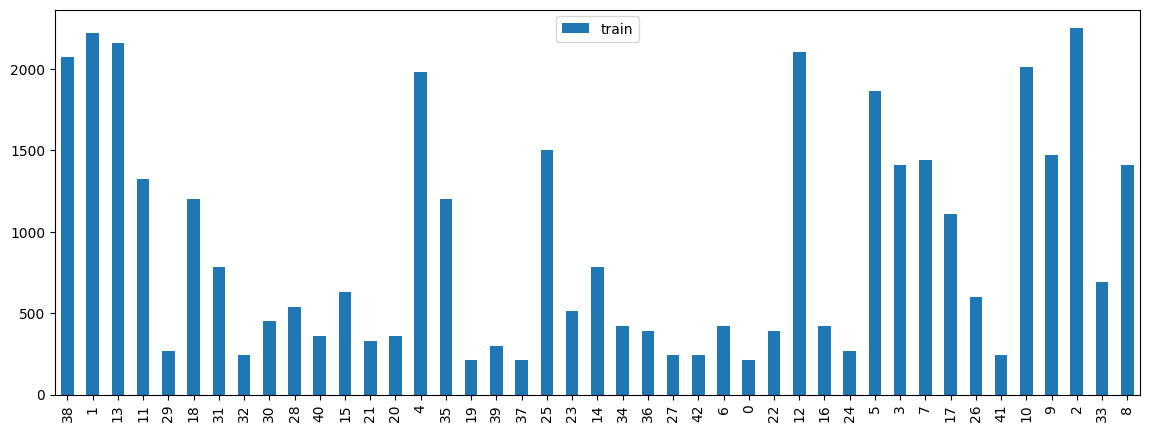

In [11]:
train_count.transpose().plot(kind='bar', figsize=(14,5))
plt.xticks(rotation='vertical')
plt.show()

# Plotting one image from each label

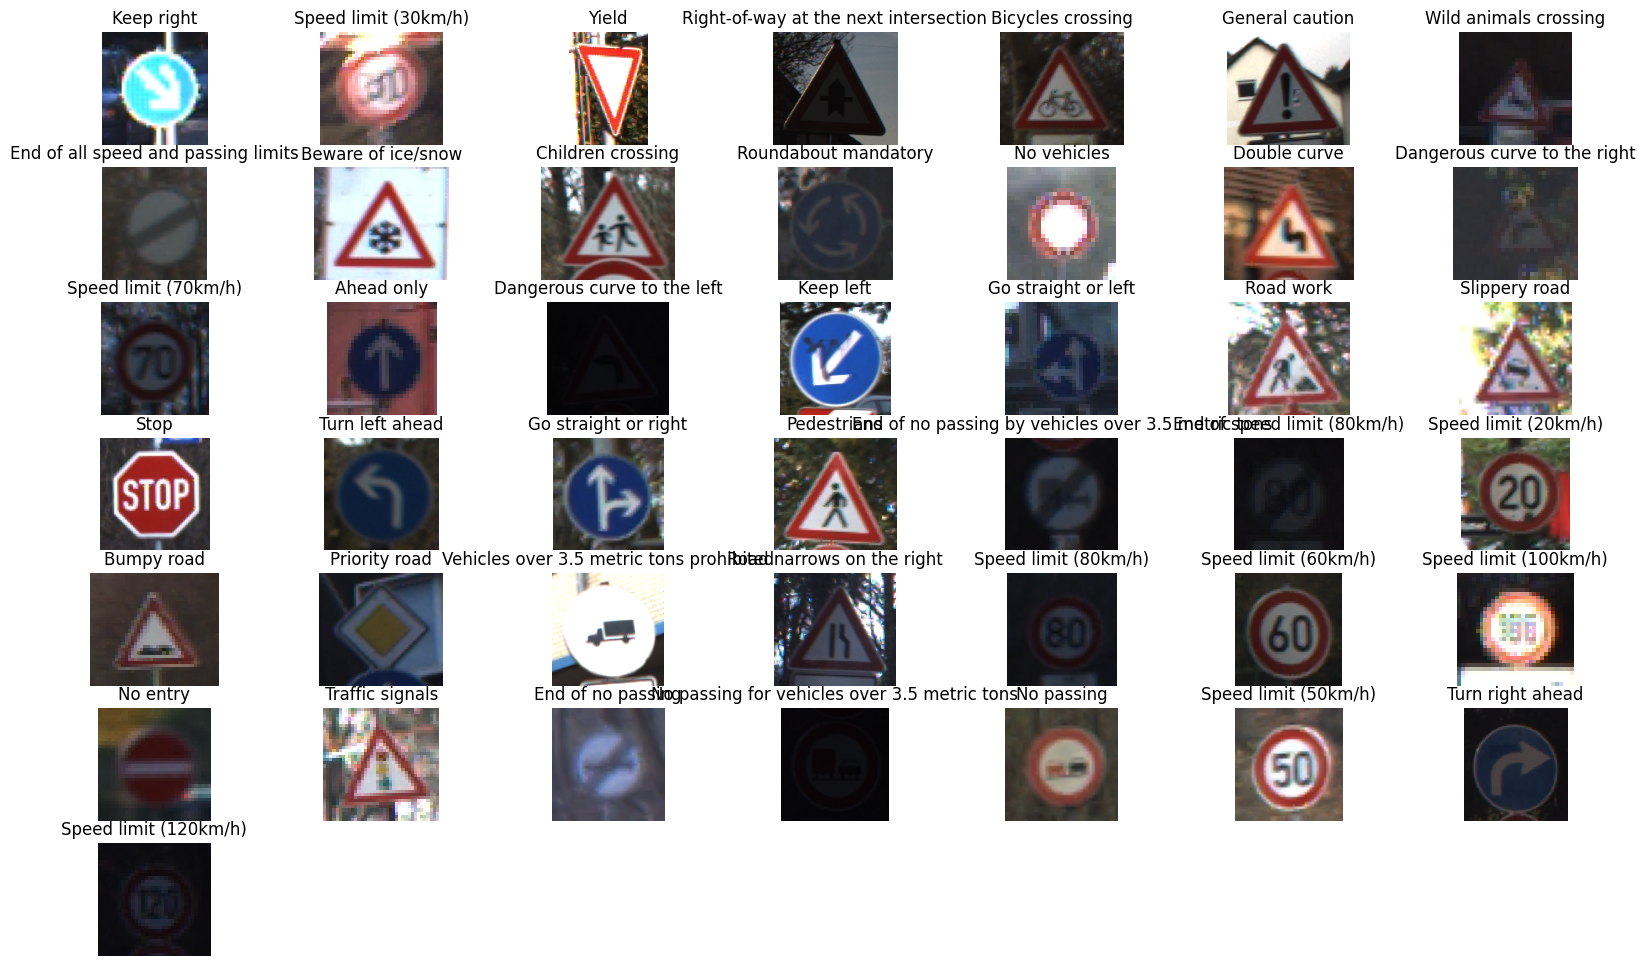

In [12]:
labels = os.listdir('/content/gtsrb-german-traffic-sign/Train')
plt.figure(figsize=(20,12))

for i, label in enumerate(labels, 1):
    folder = os.path.join(train_dir, label)
    img_path = os.path.join(folder, os.listdir(folder)[1])
    img = plt.imread(img_path)
    plt.subplot(7, 7, i)
    plt.imshow(img, cmap='gray')
    plt.title(df['SignName'][int(label)])
    plt.axis('off')

# Plotting random images from given directory

In [13]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    selected_images = random.sample(image_filenames, num_images)

    fig, axes = plt.subplots(3, 3, figsize=(12, 5))
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

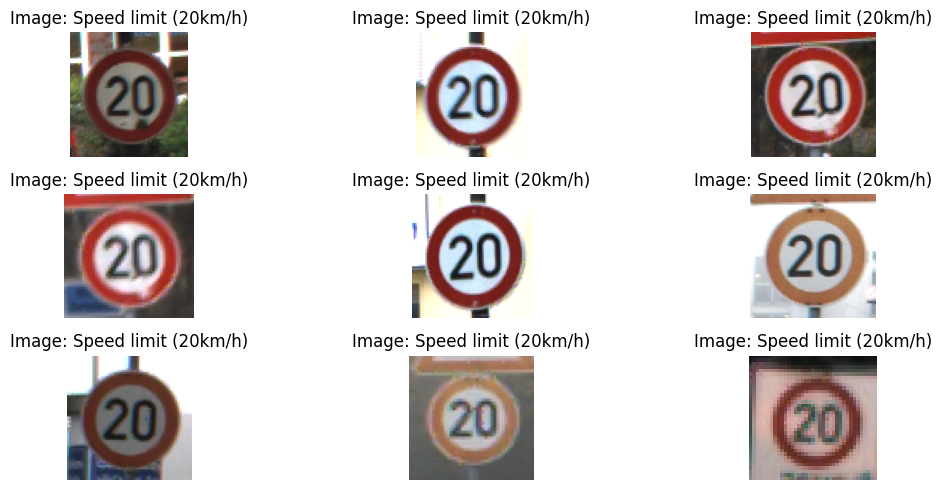

In [14]:
directory_path = '/content/gtsrb-german-traffic-sign/Train/0'
plot_images_from_directory(directory_path, class_name = df['SignName'][0])

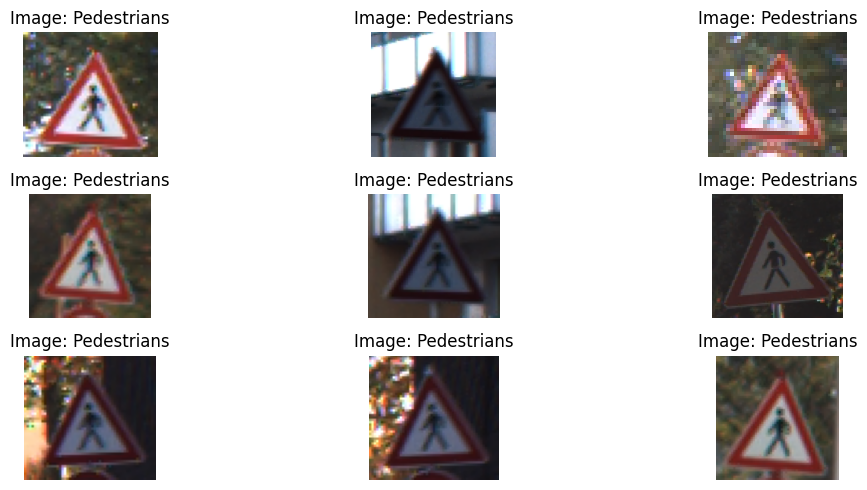

In [15]:
directory_path = '/content/gtsrb-german-traffic-sign/Train/27'
plot_images_from_directory(directory_path, class_name = df['SignName'][27])

# Checking shapes and channels

In [16]:
image = '/content/gtsrb-german-traffic-sign/Train/0/00000_00000_00000.png'

import cv2

img = cv2.imread(image)

if img is not None:
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (30, 29, 3)


# Initializing the ImageGenerators

In [17]:
train_data_dir = '/content/gtsrb-german-traffic-sign/Train'

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(32,32),
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(32,32),
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [18]:
# Accessing class labels for the training and validation data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

Training class labels: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}
Validation class labels: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}


In [19]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(43, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 10, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 3, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,0

 Total params: 173,899 (679.29 KB)

 Trainable params: 172,939 (675.54 KB)

 Non-trainable params: 960 (3.75 KB)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

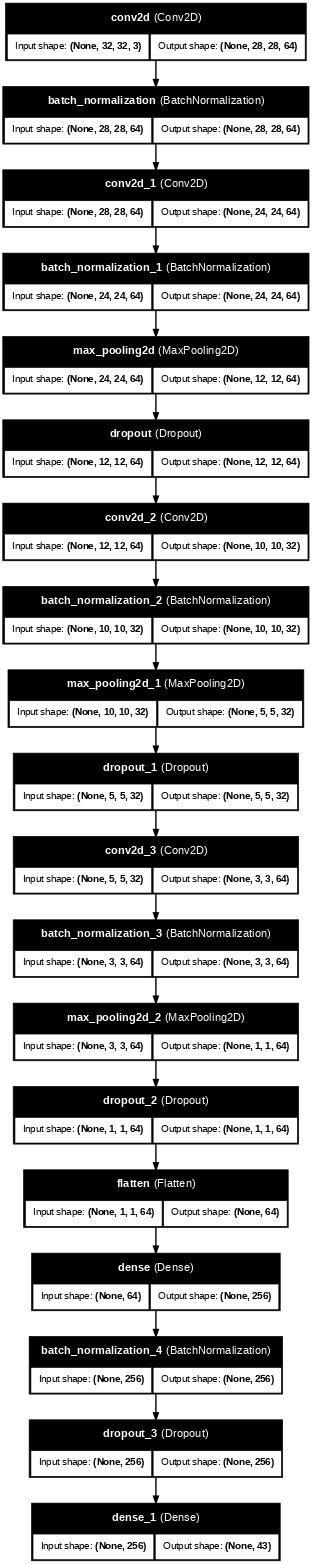

In [22]:
from keras.utils import plot_model

plot_model(model, to_file = '/content/Traffic_Sign_Recognition/Architecture.png',
           show_shapes=True, show_layer_names=True, dpi=50)

# Callbacks

In [23]:
cnn_path = '/content/Traffic_Sign_Recognition/Custom_CNN_From_Scratch'
name = 'cnn_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/Traffic_Sign_Recognition/Custom_CNN_From_Scratch/cnn_model.keras'

In [24]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=3,
                       verbose=1,
                       restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

# Model Training

In [25]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


489/491 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0789 - loss: 4.3933
Epoch 1: val_loss improved from inf to 2.85405, saving model to /content/Traffic_Sign_Recognition/Custom_CNN_From_Scratch/cnn_model.keras
491/491 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.0793 - loss: 4.3898 - val_accuracy: 0.2780 - val_loss: 2.8540 - learning_rate: 1.0000e-04
Epoch 2/100
487/491 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3286 - loss: 2.6209
Epoch 2: val_loss improved from 2.85405 to 1.69355, saving model to /content/Traffic_Sign_Recognition/Custom_CNN_From_Scratch/cnn_model.keras
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.3290 - loss: 2.6187 - val_accuracy: 0.5152 - val_loss: 1.6935 - learning_rate: 1.0000e-04
Epoch 3/100
489/491 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4606 - loss: 1.9142
Epoch 3: val_loss improved from 1.69355 to 1.32501, saving model to /content/Traffic_Sign_Recognition/Custom_CNN_From_Scratch/cnn_model.keras
491/491 ━━━━━━━━━━━━━━━━━━━━ 18s

# Plotting Performace Metrics

In [26]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

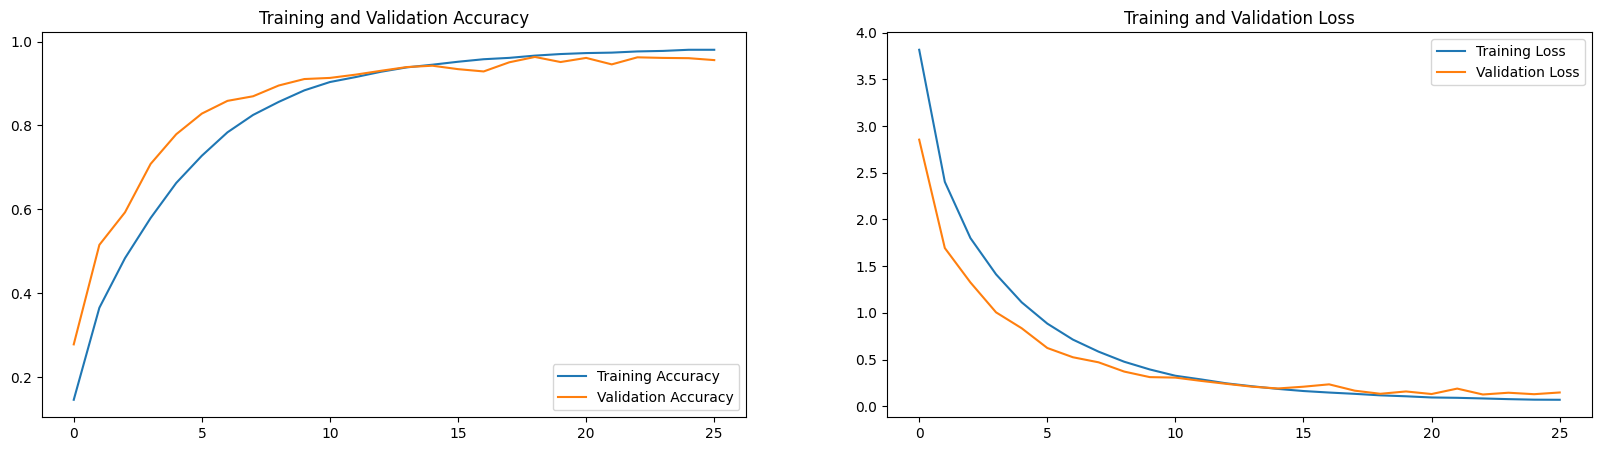

In [27]:
plot_training_history(history)

# Model Evaluation

In [28]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9979 - loss: 0.0114
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9652 - loss: 0.1204
final train accuracy = 99.80 , validation accuracy = 96.24


In [29]:
model.save("tsr_model.keras")